In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from models import ResNet
from dataset import load_mnist_dataset
from dataset import load_az_dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator #to help us efficiently augment our dataset.
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent (SGD) optimization algorithm 

from sklearn.preprocessing import LabelBinarizer #To convert our labels from integers to a vector in what is called one-hot encoding
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from imutils import build_montages #to help us build a montage from a list of images
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import cv2
import pandas as pd

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df= pd.read_csv('A_Z Handwritten Data.csv')
df.sample(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
154678,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18869,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132422,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234824,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189489,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
EPOCHS = 10       # the number of epochs to train for
INIT_LR = 1e-1    #initial learning rate
BS = 128          #batch size

# load the A-Z and MNIST datasets, respectively
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset('A_Z Handwritten Data.csv')
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...


In [17]:
azLabels , digitsLabels

(array([ 0,  0,  0, ..., 25, 25, 25]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=uint8))

In [18]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10
azLabels

array([10, 10, 10, ..., 35, 35, 35])

In [19]:
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

In [20]:
data.shape

(442451, 28, 28)

In [21]:
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
data.shape

(442451, 32, 32)

In [22]:
# add a channel dimension to every image in the dataset
data = np.expand_dims(data, axis=-1)
#scaling [0,1]
data /= 255.0

In [23]:
# convert the labels from integers to vectors : one-hot encoding
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):classWeight[i] = classTotals.max() / classTotals[i]
#test and train
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

In [24]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [25]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [26]:
# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    class_weight=classWeight,
    verbose=1)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] training network...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
2765/2765 [==============================] - 3404s 1s/step - loss: 4.1967 - accuracy: 0.7515 - val_loss: 0.5221 - val_accuracy: 0.8955
Epoch 2/10
2765/2765 [==============================] - 3466s 1s/step - loss: 1.1613 - accuracy: 0.9124 - val_loss: 0.4791 - val_accuracy: 0.9186
Epoch 3/10
2765/2765 [==============================] - 3138s 1s/step - loss: 1.0615 - accuracy: 0.9162 - val_loss: 0.4916 - val_accuracy: 0.9078
Epoch 4/10
2765/2765 [==============================] - 5245s 2s/step - loss: 1.0083 - accuracy: 0.9231 - val_loss: 0.4791 - val_accuracy: 0.9140
Epoch 5/10
2765/2765 [==============================] - 35968s 13s/step - loss: 0.9753 - accuracy: 0.9252 - val_loss: 0.4927 - val_accuracy: 0.9039
Epoch 6/10
2765/2765 [==============================] - 3557s 1s/step - loss: 0.9625 - accuracy: 0.9254

[INFO] serializing network...


c:\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


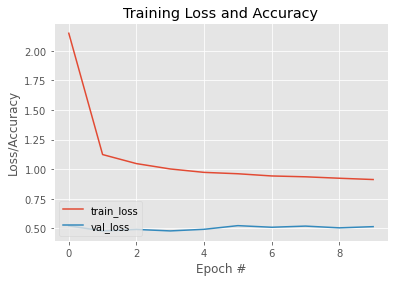

In [30]:
# save the model to disk
print("[INFO] serializing network...")
model.save('handwritings.model', save_format="h5")
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('1.jpeg')

In [33]:
# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
    # classify the character
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    # extract the image from the test data and initialize the text
    # label color as green (correct)
    image = (testX[i] * 255).astype("uint8")
    color = (0, 255, 0)
    # otherwise, the class label prediction is incorrect
    if prediction[0] != np.argmax(testY[i]):
        color = (0, 0, 255)
    # merge the channels into one image, resize the image from 32x32 to 96x96 so we can better see it and then draw the predicted label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)
    # add the image to our list of output images
    images.append(image)
    
images

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [ ]:
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2.imshow("OCR Results", montage)
# cv2.waitKey(0)